In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymannkendall as mk
plt.rcParams['figure.figsize']=(12,8)

# I. Creating a Flood Risk Index per US state

In [2]:
def replace_string(data, column):
    k_columns = data[data[column].str.contains("K")]
    k_columns = k_columns.loc[k_columns[column]!='K']
    k_columns[column] = k_columns[column].str.strip('K').astype('float') * 1000
    m_columns = data[data[column].str.contains("M")]
    m_columns = m_columns.loc[m_columns[column]!='M']
    m_columns[column] = m_columns[column].str.strip('M').astype('float') * 1e6
    b_columns = data[data[column].str.contains("B")]
    b_columns = b_columns.loc[b_columns[column]!='B']
    b_columns[column] = b_columns[column].str.strip('B').astype('float') * 1e9
    columns = pd.concat([k_columns, m_columns, b_columns], axis=0)
    
    columns = columns.sort_index()
    
    return columns

In [3]:
%%time
storm_events = []
init_path = '/Users/allanbellahsene/Desktop/THESIS/DATA/NCFEI/StormEvents_'
for years in list(np.arange(1962,2020)):
    path = init_path + str(years) + '.csv'
    storm_data = pd.read_csv(path, usecols=['BEGIN_DAY', 'MONTH_NAME', 'YEAR', 'STATE', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS'])
    storm_data.index = pd.to_datetime(storm_data['BEGIN_DAY'].astype('str')+ '-' + storm_data['MONTH_NAME'] + '-' + storm_data.YEAR.astype('str'))
    storm_data = storm_data[['STATE', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS']] #keep only relevant columns
    storm_data.dropna(inplace=True) #drop missing values
    storm_data.sort_index(inplace=True) #sort data by date
    storm_events.append(storm_data)
    #print(years)
STORMS = pd.concat([storm_events[0], storm_events[1]], axis=0)
for i in range(2, len(storm_events)):
    STORMS = pd.concat([STORMS, storm_events[i]], axis=0)
print(STORMS.shape)
df = STORMS
df['DAMAGE_PROPERTY'] = df['DAMAGE_PROPERTY'].astype('str')
df['DAMAGE_CROPS'] = df['DAMAGE_CROPS'].astype('str')
STORMS = df
STORMS = STORMS.loc[((STORMS.DAMAGE_PROPERTY!='0') & (STORMS.DAMAGE_CROPS =='0')) | ((STORMS.DAMAGE_PROPERTY=='0') & (STORMS.DAMAGE_CROPS !='0')) | ((STORMS.DAMAGE_PROPERTY!='0') & (STORMS.DAMAGE_CROPS !='0'))]
STORMS = STORMS.loc[STORMS.DAMAGE_PROPERTY!='K'] #delete rows that only contain "K"
STORMS = replace_string(STORMS, 'DAMAGE_PROPERTY')
STORMS['Date'] = STORMS.index
STORMS = STORMS[['Date','STATE', 'DAMAGE_PROPERTY']]
STORMS = STORMS.loc[STORMS['DAMAGE_PROPERTY']!=0]
df = STORMS.groupby(['STATE', 'Date']).agg({'DAMAGE_PROPERTY':sum})
States = list(STORMS.STATE.unique())

(925229, 3)
CPU times: user 16.4 s, sys: 2.55 s, total: 18.9 s
Wall time: 20.8 s


In [4]:
df

DAMAGE_PROPERTY
STATE   Date                       
ALABAMA 1962-01-05          52500.0
        1962-03-21         275000.0
        1962-03-25          50000.0
        1962-03-30          25000.0
        1962-03-31         525000.0
...                             ...
WYOMING 2019-07-31           2000.0
        2019-08-10          25000.0
        2019-08-14           5000.0
        2019-08-21            500.0
        2019-08-25           2000.0

[49501 rows x 1 columns]

In [12]:
def rank_states(data, states, by, damage_type, frequency, min_date, max_date):
    
    import pymannkendall as mk
    import pandas as pd
    import numpy as np
    import scipy
    
    loss_per_state = []
    for state in states:
        df = pd.DataFrame(data=data.xs(state, level='STATE'))
        df['Date'] = df.index
        df = df.resample(frequency, on='Date').sum()
        state_name = [state] * len(df)
        state_name = pd.DataFrame(state_name, columns=["State"])
        state_name.index = df.index
        df = pd.concat([df, state_name], axis=1)
        loss_per_state.append(df)
    for i in range(len(loss_per_state)):
        loss_per_state[i] = loss_per_state[i].loc[(loss_per_state[i].index>=min_date) & (loss_per_state[i].index<=max_date)]
        
    if frequency == 'Y':
        loss_per_state = [s for s in loss_per_state if len(s)>=2]
    elif frequency == 'M':
        loss_per_state = [s for s in loss_per_state if len(s)>=20]
    else:
        print('This frequency is not available')
    
    if by == 'trend':
        trend_data = []
        for i in range(len(loss_per_state)):
            df = loss_per_state[i].DAMAGE_PROPERTY
            trend,h,p,z,Tau,s,var_s,slope,intercept = mk.original_test(df)
            sen_slope = scipy.stats.mstats.theilslopes(df)[0]
            location = loss_per_state[i].State.iloc[0]
            trend_data.extend((location, trend, sen_slope, Tau, p))
        n = int(len(trend_data)/5)
        trend_data = np.array(trend_data).reshape((n, 5))
        trend_data = pd.DataFrame(data=trend_data, columns=['State', 'Trend', 'Sen Slope', 'Kendall Tau', 'P-value'])
        trend_data[['Kendall Tau']] = trend_data[['Kendall Tau']].astype('float')
        trend_data['Sen Slope'] = trend_data['Sen Slope'].astype('float')
        trend_data['P-value'] = trend_data['P-value'].astype('float')
        trend_data = trend_data.sort_values(by='Sen Slope', ascending=False)
        
        ranking = trend_data
        ranking.reset_index(inplace=True)
        ranking = ranking.drop(columns=['index'])
        
    elif by =='VaR':
        value_at_risk = []
        for i in range(len(loss_per_state)):
            VaR = loss_per_state[i].DAMAGE_PROPERTY.quantile(0.99)
            state = loss_per_state[i].State.iloc[0]
            value_at_risk.extend((state, VaR))
        n = int(len(value_at_risk)/2)
        value_at_risk = np.array(value_at_risk).reshape((n, 2))
        value_at_risk = pd.DataFrame(data=value_at_risk, columns=['State', 'Value-at-Risk (VaR)'])
        value_at_risk['Value-at-Risk (VaR)'] = value_at_risk['Value-at-Risk (VaR)'].astype('float')
        
        VaR_ranking = value_at_risk.sort_values(by='Value-at-Risk (VaR)', ascending=False)
        VaR_ranking = VaR_ranking.reset_index(drop=True)
        ranking = VaR_ranking
        
    elif by =='Average Loss':
        mean_annual_loss = []
        for i in range(len(loss_per_state)):
            mean_loss = np.mean(loss_per_state[i].DAMAGE_PROPERTY)
            state = loss_per_state[i].State.iloc[0]
            mean_annual_loss.extend((state, mean_loss))
        n = int(len(mean_annual_loss)/2)
        mean_annual_loss = np.array(mean_annual_loss).reshape((n, 2))
        mean_annual_loss = pd.DataFrame(data=mean_annual_loss, columns=['State', 'Average Annual Loss'])
        mean_annual_loss['Average Annual Loss'] = mean_annual_loss['Average Annual Loss'].astype('float')
    
        ranking = mean_annual_loss
        ranking = ranking.sort_values(by='Average Annual Loss', ascending=False)
        ranking.reset_index(inplace=True)
        ranking = ranking.drop(columns=['index'])
    
    else:
        print('This risk measure is not allowed.')
    
    
    
    
    return ranking      

In [17]:
ranking = rank_states(data=df, states=States, by='trend', frequency='M', min_date = '1996-01-01', max_date='2010-01-01')

In [18]:
ranking

,State,Trend,Sen Slope,Kendall Tau,P-value
0,TEXAS,increasing,7940.909091,0.138651,7.644911e-03
1,PENNSYLVANIA,increasing,500.000000,0.337325,7.668532e-12
2,FLORIDA,no trend,482.320099,0.080767,1.191544e-01
3,KANSAS,increasing,363.269795,0.200029,6.966689e-05
4,KENTUCKY,increasing,250.000000,0.172013,8.730537e-04
...,...,...,...,...,...
56,MINNESOTA,increasing,0.000000,0.113345,1.010555e-02
57,MONTANA,increasing,0.000000,0.202595,4.533559e-07
58,OREGON,increasing,0.000000,0.169661,4.732081e-05
59,OHIO,increasing,0.000000,0.225763,5.093334e-07


In [7]:
ranking = rank_states(data=df, states=States, by='VaR', frequency='Y', min_date='1960-01-01', max_date='2001-01-01')
ranking.head()

,State,Value-at-Risk (VaR)
0,NORTH CAROLINA,2.402494e+09
1,PUERTO RICO,1.604400e+09
2,TEXAS,1.391961e+09
3,FLORIDA,1.293433e+09
4,GEORGIA,9.191370e+08


In [10]:
ranking = rank_states(data=df, states=States, by='Average Loss', frequency='Y', min_date='1960-01-01', max_date='2000-01-01')
ranking.head()

,State,Average Annual Loss
0,PUERTO RICO,2.988896e+08
1,TEXAS,1.692860e+08
2,NORTH CAROLINA,1.355452e+08
3,FLORIDA,8.088618e+07
4,GEORGIA,6.227532e+07


In [12]:
def classify_states(ranking, method):
    if method == 'trend':
        ranking = ranking.loc[ranking['P-value'] < 0.05]
    elif method == 'VaR' or method == 'Average Loss':
        ranking = ranking
    
    n = len(ranking)
    l = int(n/4)
    q1 = ranking.iloc[0:l, :]
    q2 = ranking.iloc[l:2*l, :]
    q3 = ranking.iloc[2*l:3*l, :]
    q4 = ranking.iloc[3*l:n, :]
    
    return q1,q2,q3,q4
    
        

In [13]:
q1,q2,q3,q4 = classify_states(ranking=rank_states(data=df, states=States, by='trend', frequency='Y', min_date='1960-01-01', max_date='2001-01-01'),
                             method='trend')

In [14]:
q4

,State,Trend,Sen Slope,Kendall Tau,P-value
29,MARYLAND,increasing,39791.666667,0.348790,0.005250
30,IDAHO,increasing,31487.500000,0.554348,0.000160
31,WEST VIRGINIA,increasing,27472.222222,0.367816,0.004415
33,NEW MEXICO,increasing,22181.818182,0.376114,0.001851
34,ARIZONA,increasing,18894.230769,0.260081,0.037107
35,MONTANA,increasing,13187.500000,0.242017,0.042157
37,OREGON,increasing,12562.500000,0.363636,0.018673
38,WYOMING,increasing,11182.000000,0.252101,0.034326
40,UTAH,increasing,6006.000000,0.383399,0.011100


In [15]:
q1,q2,q3,q4 = classify_states(ranking=rank_states(data=df, states=States, by='VaR', frequency='Y', min_date='1960-01-01', max_date='2001-01-01'),
                             method='VaR')

In [16]:
q4

,State,Value-at-Risk (VaR)
39,WYOMING,20026245.8
40,MASSACHUSETTS,19522427.5
41,NEW MEXICO,18864745.4
42,MONTANA,17165650.0
43,HAWAII,13050050.0
44,VERMONT,8575000.0
45,NEW HAMPSHIRE,5429095.0
46,DELAWARE,4572500.0
47,RHODE ISLAND,2917500.0
48,IDAHO,2705950.0


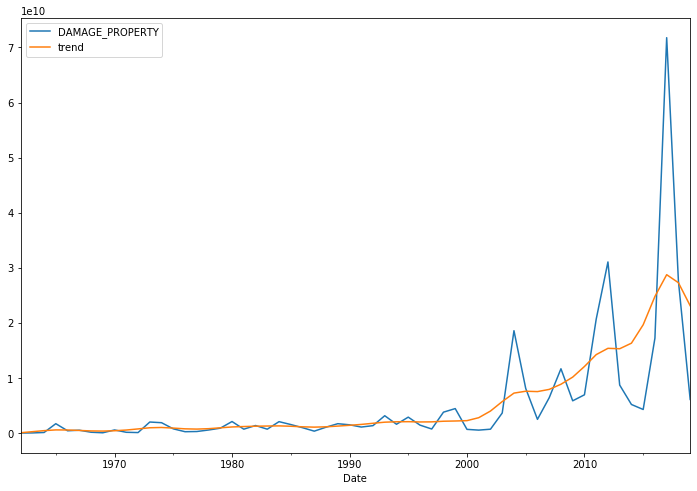

In [7]:
STORMS = STORMS.loc[((STORMS.DAMAGE_PROPERTY!='0.00K') & (STORMS.DAMAGE_CROPS=='0.00K')) | ((STORMS.DAMAGE_PROPERTY=='0.00K') & (STORMS.DAMAGE_CROPS!='0.00K')) | ((STORMS.DAMAGE_PROPERTY!='0.00K') & (STORMS.DAMAGE_CROPS!='0.00K'))]
storm_data = STORMS
column = 'DAMAGE_PROPERTY'
storm_data = storm_data[(storm_data[column].str.contains('K', na=False)) | (storm_data[column].str.contains('M', na=False)) | (storm_data[column].str.contains('B', na=False))]
dam_props = replace_string(storm_data, 'DAMAGE_PROPERTY')
df = dam_props.groupby(dam_props.index).agg({'DAMAGE_PROPERTY':sum})
df['Date'] = df.index
annual_data = df.resample('Y', on='Date').sum()
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(annual_data, 6.25)
annual_data['trend'] = trend.values
annual_data.plot()

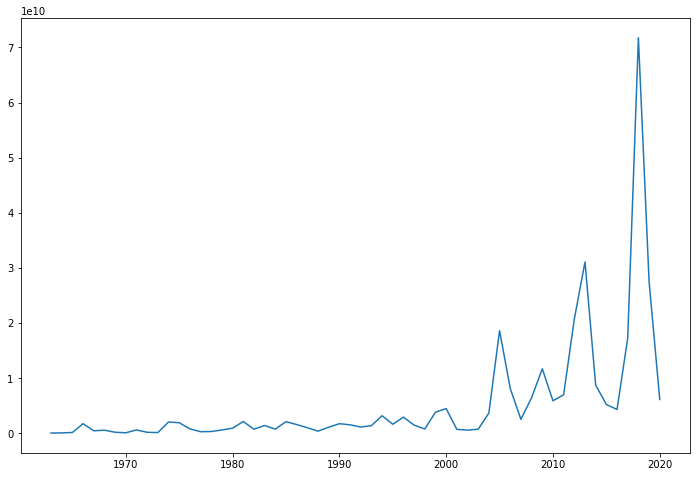

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12,8)
plt.plot(df.resample('Y', on='Date').sum())

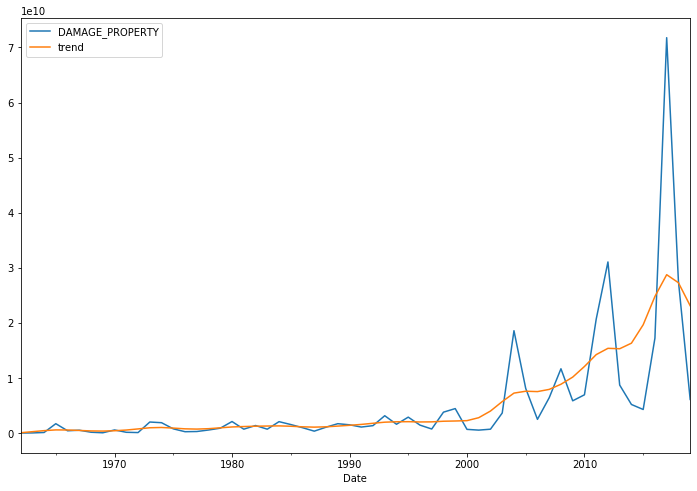

In [84]:
annual_data.plot()

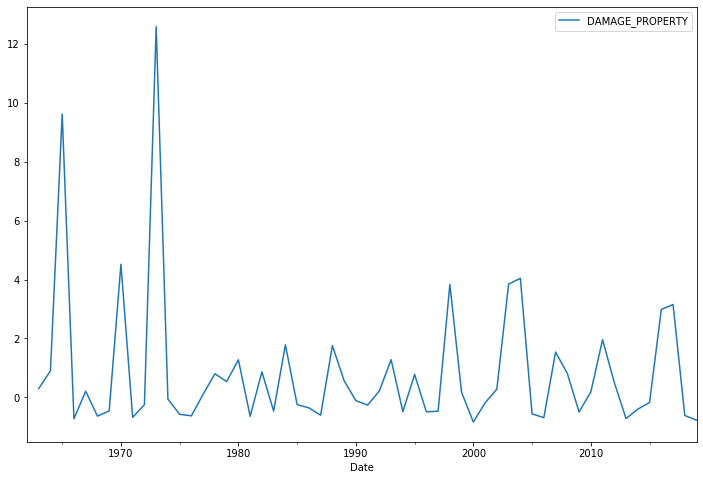

In [82]:
annual_data[['DAMAGE_PROPERTY']].pct_change().plot()

# II. Financial Data

In [ ]:
def ClimateRisk_Perf_Corr(data, sector, min_date, max_date):
    df = da

In [23]:
#Financial fundamental data


fundamentals = pd.read_csv('/Users/allanbellahsene/Desktop/THESIS/DATA/WHARTON_DATABASE/Funda_data.csv')
uti_naics = '2211'
ins_naics = '524126'
uti_fonda = fundamentals[['gvkey', 'datadate', 'fqtr', 'tic', 'conm', 'atq', 'niq', 'loc', 'state', 'naics']]
uti_fonda = uti_fonda.loc[uti_fonda['loc'] == 'USA'] #keep only utility companies with headquarters in the US
uti_comp_names = list(uti_fonda.conm.unique()) 
uti_comp_gvkey = list(uti_fonda.gvkey.unique())
uti_states = list(uti_fonda.state.unique())

In [24]:
%%time


#Stock data


stocks = pd.read_csv('/Users/allanbellahsene/Desktop/THESIS/DATA/WHARTON_DATABASE/Monthly_stocks.csv')
uti_stocks = []
for keys in uti_comp_gvkey:
    stock = stocks.loc[stocks.gvkey==keys]
    uti_stocks.append(stock)

stocks_data = pd.concat([uti_stocks[0], uti_stocks[1]], axis=0)
for i in range(2, len(uti_stocks)):
    stocks_data = pd.concat([stocks_data, uti_stocks[i]], axis=0)

CPU times: user 11.2 s, sys: 2.33 s, total: 13.5 s
Wall time: 14.3 s


In [25]:
stocks_data[['Date']] = stocks_data[['datadate']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[4:6],s[6:], s[0:4]))
stocks_data.index = pd.to_datetime(stocks_data.Date)

In [27]:
stocks_data.loc[stocks_data.tic==''].gsubind.unique()

array([40301040.])

In [21]:
uti_fonda[['Date']] = uti_fonda[['datadate']].applymap(str).applymap(lambda s: "{}/{}/{}".format(s[4:6],s[6:], s[0:4]))
uti_fonda.index = pd.to_datetime(uti_fonda.Date)

In [22]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [24]:
#state_city['abbrev'] = state_city['State'].map(state_2)
uti_fonda['State'] = uti_fonda['state'].map(abbrev_us_state)

In [25]:
uti_fonda.State = uti_fonda.State.str.upper()

In [26]:
uti_fonda = uti_fonda[['gvkey', 'tic', 'conm', 'atq', 'niq', 'State']]

In [27]:
uti_fonda.dropna(inplace=True)
uti_fonda['roa'] = uti_fonda['niq'] / uti_fonda['atq']
uti_fonda.dropna(inplace=True)

In [28]:
q1,q2,q3,q4 = classify_states(ranking=rank_states(data=df, states=States, by='Average Loss', frequency='Y', min_date='1995-01-01', max_date='2001-01-01'),
                             method='Average Loss')

In [29]:
q1

,State,Average Annual Loss
0,NORTH CAROLINA,7.011104e+08
1,TEXAS,5.029253e+08
2,PUERTO RICO,4.482555e+08
3,FLORIDA,1.859329e+08
4,ALABAMA,7.927548e+07
5,WISCONSIN,5.944309e+07
6,IOWA,4.821130e+07
7,NEBRASKA,4.275380e+07
8,NEW YORK,4.261033e+07
9,COLORADO,3.943517e+07


In [30]:
def segregate_performance(clim_data, fin_data, min_date, max_date, method):
    q1,q2,q3,q4 = classify_states(ranking=rank_states(data=clim_data, states=States, by=method, frequency='Y', min_date=min_date, max_date=max_date),
                                 method=method)
    
    fin_data = fin_data.loc[(fin_data.index>=min_date) & (fin_data.index<=max_date)]
    
    q1_fin = fin_data.loc[fin_data['State'].isin(list(q1.State))]
    q2_fin = fin_data.loc[fin_data['State'].isin(list(q2.State))]
    q3_fin = fin_data.loc[fin_data['State'].isin(list(q3.State))]
    q4_fin = fin_data.loc[fin_data['State'].isin(list(q4.State))]
    
    comp_q1 = list(q1_fin.conm.unique())
    comp_q2 = list(q2_fin.conm.unique())
    comp_q3 = list(q3_fin.conm.unique())
    comp_q4 = list(q4_fin.conm.unique())
    
    #sub_q1 = q1_fin.loc[(q1_fin.index>=min_date) & (q1_fin.index<=max_date)]
    #subq1_comp = list(sub_q1.conm.unique())
    ROA_q1 = []
    for companies in comp_q1:
        df = fin_data.loc[fin_data.conm==companies]
        mean_roa = df.roa.mean()
        if abs(mean_roa) < 10:
            ROA_q1.append(mean_roa)
    ROA_q1 = np.array(ROA_q1).reshape(-1,1)
    ROA_q1 = ROA_q1[~np.isnan(ROA_q1)]
    n_q1 = len(ROA_q1)
    meanROA_q1 = np.mean(ROA_q1)
    
    
    ROA_q2 = []
    for companies in comp_q2:
        df = fin_data.loc[fin_data.conm==companies]
        mean_roa = df.roa.mean()
        if abs(mean_roa) < 10:
            ROA_q2.append(mean_roa)
    ROA_q2 = np.array(ROA_q2).reshape(-1,1)
    ROA_q2 = ROA_q2[~np.isnan(ROA_q2)]
    n_q2 = len(ROA_q2)
    meanROA_q2 = np.mean(ROA_q2)
    

    ROA_q3 = []
    for companies in comp_q3:
        df = fin_data.loc[fin_data.conm==companies]
        mean_roa = df.roa.mean()
        if abs(mean_roa) < 10:
            ROA_q3.append(mean_roa)
    ROA_q3 = np.array(ROA_q3).reshape(-1,1)
    ROA_q3 = ROA_q3[~np.isnan(ROA_q3)]
    n_q3 = len(ROA_q3)
    meanROA_q3 = np.mean(ROA_q3)
    

    ROA_q4 = []
    for companies in comp_q4:
        df = fin_data.loc[fin_data.conm==companies]
        mean_roa = df.roa.mean()
        if abs(mean_roa) < 10:
            ROA_q4.append(mean_roa)
    ROA_q4 = np.array(ROA_q4).reshape(-1,1)
    ROA_q4 = ROA_q4[~np.isnan(ROA_q4)]
    n_q4 = len(ROA_q4)
    meanROA_q4 = np.mean(ROA_q4)
    
    q_df = [['Q1', meanROA_q1, n_q1], ['Q2', meanROA_q2, n_q2], ['Q3', meanROA_q3, n_q3], ['Q4', meanROA_q4, n_q4]]
    
    q_df = pd.DataFrame(data=q_df, columns=['Quartile', 'Mean ROA', 'Number of companies'])
    
    
    return q_df
    


In [31]:
segregate_performance(clim_data=df, fin_data=uti_fonda, min_date='1960-01-01', max_date='2001-01-01', method='Average Loss')

,Quartile,Mean ROA,Number of companies
0,Q1,0.006491,52
1,Q2,0.006333,61
2,Q3,0.000991,32
3,Q4,0.010690,9


In [94]:
segregate_performance(clim_data=df, fin_data=uti_fonda, min_date='2000-01-01', max_date='2002-01-01', method='Average Loss')

,Quartile,Mean ROA,Number of companies
0,Q1,0.001279,24
1,Q2,-0.013453,11
2,Q3,0.005211,3
3,Q4,-0.013296,35


In [96]:
segregate_performance(clim_data=df, fin_data=uti_fonda, min_date='1990-01-01', max_date='1991-01-01', method='Average Loss')

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Quartile,Mean ROA,Number of companies
0,Q1,NaN,0
1,Q2,NaN,0
2,Q3,NaN,0
3,Q4,NaN,0


In [63]:
segregate_performance(clim_data=df, fin_data=uti_fonda, min_date='2001-01-01', max_date='2003-01-01', method='VaR')

,Quartile,Mean ROA,Number of companies
0,Q1,-0.000534,13
1,Q2,-0.013457,21
2,Q3,0.003945,31
3,Q4,0.006459,10


In [66]:
segregate_performance(clim_data=df, fin_data=uti_fonda, min_date='2003-01-01', max_date='2005-01-01', method='Average Loss')

,Quartile,Mean ROA,Number of companies
0,Q1,0.007150,19
1,Q2,-0.000614,18
2,Q3,0.002990,31
3,Q4,0.812065,6


In [67]:
stocks_data['State'] = stocks_data['state'].map(abbrev_us_state)

In [68]:
stocks_data.State = stocks_data.State.str.upper()

In [69]:
stocks_data

,gvkey,iid,datadate,tic,conm,prccm,trt1m,gsubind,loc,naics,state,Date,State
Date,,,,,,,,,,,,,
1971-11-30,1097,01,19711130,ACMT,ACMAT CORP -CL A,9.75,NaN,40301040.0,USA,524126.0,CT,11/30/1971,CONNECTICUT
1971-12-31,1097,01,19711231,ACMT,ACMAT CORP -CL A,14.25,46.1538,40301040.0,USA,524126.0,CT,12/31/1971,CONNECTICUT
1972-01-31,1097,01,19720131,ACMT,ACMAT CORP -CL A,25.75,80.7017,40301040.0,USA,524126.0,CT,01/31/1972,CONNECTICUT
1972-02-29,1097,01,19720229,ACMT,ACMAT CORP -CL A,48.00,86.4078,40301040.0,USA,524126.0,CT,02/29/1972,CONNECTICUT
1972-03-31,1097,01,19720331,ACMT,ACMAT CORP -CL A,56.00,16.6666,40301040.0,USA,524126.0,CT,03/31/1972,CONNECTICUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-02-28,186230,01C,20130228,AFH.,ATLAS FINANCIAL HOLDINGS INC,6.20,-26.1905,40301040.0,USA,524126.0,IL,02/28/2013,ILLINOIS
2013-03-31,186230,01C,20130331,AFH.,ATLAS FINANCIAL HOLDINGS INC,6.00,-3.2258,40301040.0,USA,524126.0,IL,03/31/2013,ILLINOIS
2013-04-30,186230,01C,20130430,AFH.,ATLAS FINANCIAL HOLDINGS INC,7.35,22.5000,40301040.0,USA,524126.0,IL,04/30/2013,ILLINOIS


In [70]:
stocks_data = stocks_data.loc[stocks_data['loc'] == 'USA']
stocks_data = stocks_data[['gvkey', 'tic', 'conm', 'State', 'prccm', 'trt1m']]

In [72]:
q1_stocks = stocks_data.loc[stocks_data['State'].isin(list(q1.State))]
q2_stocks = stocks_data.loc[stocks_data['State'].isin(list(q2.State))]
q3_stocks = stocks_data.loc[stocks_data['State'].isin(list(q3.State))]
q4_stocks = stocks_data.loc[stocks_data['State'].isin(list(q4.State))]

In [73]:
q1_stocks

,gvkey,tic,conm,State,prccm,trt1m
Date,,,,,,
1974-01-31,1274,Y,ALLEGHANY CORP,NEW YORK,11.25,NaN
1974-02-28,1274,Y,ALLEGHANY CORP,NEW YORK,11.00,-2.2222
1974-03-31,1274,Y,ALLEGHANY CORP,NEW YORK,10.25,-6.8182
1974-04-30,1274,Y,ALLEGHANY CORP,NEW YORK,10.50,2.4391
1974-05-31,1274,Y,ALLEGHANY CORP,NEW YORK,8.25,-19.5239
...,...,...,...,...,...,...
2020-01-31,179974,HCI,HCI GROUP INC,FLORIDA,44.27,-3.0230
2008-07-31,179974,HCIIU,HCI GROUP INC,FLORIDA,6.62,NaN
2008-08-31,179974,HCIIU,HCI GROUP INC,FLORIDA,6.63,0.1511


In [160]:
subq1_stocks = q1_stocks.loc[(q1_stocks.index >='2000-01-01') & (q1_stocks.index <='2001-01-01')]
mean_returns=[]
for companies in subq1_comp:
    data = subq1_stocks.loc[subq1_stocks.conm==companies]
    data['Monthly Return'] = data.prccm.pct_change()
    data.dropna(inplace=True)
    data = data.loc[(data['Monthly Return'] < 1000) & (data['Monthly Return']) > -1000]
    av_return = data['Monthly Return'].mean()
    mean_returns.append(av_return)
mean_returns = np.array(mean_returns).reshape(-1,1)
mean_returns = mean_returns[~np.isnan(mean_returns)]
np.mean(mean_returns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.020155707087268746

In [161]:
subq2_stocks = q2_stocks.loc[(q2_stocks.index >='2000-01-01') & (q2_stocks.index <='2001-01-01')]
mean_returns=[]
for companies in subq2_comp:
    data = subq2_stocks.loc[subq2_stocks.conm==companies]
    data['Monthly Return'] = data.prccm.pct_change()
    data.dropna(inplace=True)
    data = data.loc[(data['Monthly Return'] < 1000) & (data['Monthly Return']) > -1000]
    av_return = data['Monthly Return'].mean()
    mean_returns.append(av_return)
mean_returns = np.array(mean_returns).reshape(-1,1)
mean_returns = mean_returns[~np.isnan(mean_returns)]
np.mean(mean_returns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.017805809647963442

In [162]:
subq3_stocks = q3_stocks.loc[(q3_stocks.index >='2000-01-01') & (q3_stocks.index <='2001-01-01')]
mean_returns=[]
for companies in subq3_comp:
    data = subq3_stocks.loc[subq3_stocks.conm==companies]
    data['Monthly Return'] = data.prccm.pct_change()
    data.dropna(inplace=True)
    data = data.loc[(data['Monthly Return'] < 1000) & (data['Monthly Return']) > -1000]
    av_return = data['Monthly Return'].mean()
    mean_returns.append(av_return)
mean_returns = np.array(mean_returns).reshape(-1,1)
mean_returns = mean_returns[~np.isnan(mean_returns)]
np.mean(mean_returns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0.026587336135328814

In [163]:
subq4_stocks = q4_stocks.loc[(q4_stocks.index >='2000-01-01') & (q4_stocks.index <='2001-01-01')]
mean_returns=[]
for companies in subq4_comp:
    data = subq4_stocks.loc[subq4_stocks.conm==companies]
    data['Monthly Return'] = data.prccm.pct_change()
    data.dropna(inplace=True)
    data = data.loc[(data['Monthly Return'] < 1000) & (data['Monthly Return']) > -1000]
    av_return = data['Monthly Return'].mean()
    mean_returns.append(av_return)
mean_returns = np.array(mean_returns).reshape(-1,1)
mean_returns = mean_returns[~np.isnan(mean_returns)]
np.mean(mean_returns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.027573233039610248

In [157]:
np.mean?

In [ ]:
subq1_comp = list(sub_q1.conm.unique())
ROA = []
for companies in subq1_comp:
    data = sub_q1.loc[sub_q1.conm==companies]
    mean_roa = data.roa.mean()
    ROA.append(mean_roa)
ROA = [x for x in ROA if abs(x) < 10]
print(np.mean(ROA))